# Imports

In [ ]:
# Restart session after running this cell
!pip install pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import ast
import string

from tabulate import tabulate
from wordcloud import WordCloud
from collections import Counter
from IPython.display import display
from itertools import islice
from nltk.util import ngrams
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

In [ ]:
# Mount google drive (If Using G-Drive, Else use local import below)
from google.colab import drive
drive.mount('/content/drive')

# Load Dataset

In [ ]:
# Load dataset via shared google drive folder
#df_listings_tokens = pd.read_csv('/content/drive/MyDrive/BAP Practice Module/BAP Final Report/Data/Final Dimension Model Tables/dim_listings.csv')
#df_fact_avail = pd.read_csv('/content/drive/MyDrive/BAP Practice Module/BAP Final Report/Data/Final Dimension Model Tables/fact_availability.csv')
#df_host = pd.read_csv('/content/drive/MyDrive/BAP Practice Module/BAP Final Report/Data/Final Dimension Model Tables/dim_hosts.csv')
#df_reviews_tokens = pd.read_csv('/content/drive/MyDrive/BAP Practice Module/BAP Final Report/Data/Final Dimension Model Tables/dim_reviews.csv')

# Alternatively load data via local file upload
dim_listing = pd.read_excel('dim_listings.xlsx')
dim_host = pd.read_excel('dim_hosts.xlsx')
dim_reviews = pd.read_excel('dim_reviews.xlsx')
#fact_availability = pd.read_excel('fact_availability.xlsx')

In [ ]:
df_listings_data = dim_listing.merge(
    dim_host[['host_id', 'host_about_tokens']].drop_duplicates(subset='host_id'),
    on='host_id',
    how='left'
)

df_reviews_data = dim_reviews.copy()

#df_listings_data and df_reviews_data will be used for futher Text Analytics.

# Tokenisation into List

In [ ]:
# Performance Tuning
# To improves performance by processing texts in parallel
# Tested with runtime improved by 48%
nlp = spacy.load("en_core_web_sm")

def tokenize_batch(texts):
    results = []
    for doc in nlp.pipe(texts):
        if pd.isnull(doc):
            results.append([])
        else:
            results.append([token.text for token in doc])
    return results

df_listings_tokens = df_listings_data.copy()
columns_to_tokenize = ['name_tokens', 'description_tokens', 'neighborhood_overview_tokens', 'host_about_tokens']

for column in columns_to_tokenize:
    df_listings_tokens[column] = tokenize_batch(df_listings_tokens[column].astype(str).tolist())

# Export tokenized text to save computing resources by loading xlsx file in future.
# Export df_listings_tokens as excel file
df_listings_tokens.to_excel('df_listings_tokens.xlsx', index=False)

In [ ]:
# Import the list of tokens df, where function tokenize_batch has been applied
df_listings_tokens = pd.read_excel('df_listings_tokens.xlsx')

In [ ]:
# Function to parse and ensure clean tokens
def fix_list_strings(cell):
    if isinstance(cell, str):
        try:
            return ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            return []  # Return empty list if parsing fails
    return cell

# Define columns to clean
columns_to_analyze = ['name_tokens', 'description_tokens', 'neighborhood_overview_tokens', 'host_about_tokens']

# Apply the fix and cleaning to each column
for column in columns_to_analyze:
    df_listings_tokens[column] = df_listings_tokens[column].apply(fix_list_strings)


In [ ]:
# For reviews
nlp = spacy.load("en_core_web_sm")

def tokenize_text(text):
    # If text is NaN or None, return an empty list
    if pd.isnull(text):
        return []
    # Otherwise, tokenize the string
    return [token.text for token in nlp(str(text))]

df_reviews_tokens = df_reviews_data.copy()
columns_to_tokenize = ['comments_tokens']
df_reviews_tokens[columns_to_tokenize] = df_reviews_tokens[columns_to_tokenize].applymap(tokenize_text)

# Export tokenized text to save computing resources by loading xlsx file in future.
# Export df_reviews_tokens as excel file
df_reviews_tokens.to_excel('df_reviews_tokens.xlsx', index=False)

<ipython-input-9-8ebc822a5a17>:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_reviews_tokens[columns_to_tokenize] = df_reviews_tokens[columns_to_tokenize].applymap(tokenize_text)


In [ ]:
# Import the list of tokens df, if needed
df_reviews_tokens = pd.read_excel('df_reviews_tokens.xlsx')

In [ ]:
# Define columns to analyze
columns_to_analyze_reviews = ['comments_tokens']

for column in columns_to_analyze_reviews:
    df_reviews_tokens[column] = df_reviews_tokens[column].apply(fix_list_strings)

# Top-30 Tokens

## Top-30 Tokens: Listings

In [ ]:
# define columns to analyze
columns_to_analyze = ['name_tokens', 'description_tokens', 'neighborhood_overview_tokens', 'host_about_tokens']

for column in columns_to_analyze:
    df_listings_tokens[column] = df_listings_tokens[column].apply(fix_list_strings)

# function to get top 30 tokens from a column
def get_top_tokens(column):
    all_tokens = [token for sublist in df_listings_tokens[column] for token in sublist]  # Flatten list
    token_counts = Counter(all_tokens)
    return token_counts.most_common(30)  # Get top 30

# get top 30 tokens for each column
top_tokens_per_column = {col: get_top_tokens(col) for col in columns_to_analyze}

# display results
top_tokens_df = pd.DataFrame.from_dict(top_tokens_per_column, orient='index').transpose()

# use display from IPython.display
display(top_tokens_df)

,name_tokens,description_tokens,neighborhood_overview_tokens,host_about_tokens
0,"(room, 503)","(br, 2930)","(br, 2016)","(singapore, 1447)"
1,"(studio, 379)","(apartment, 1176)","(walk, 2000)","(apartments, 1238)"
2,"(apartment, 360)","(room, 1159)","(mrt, 1773)","(stay, 845)"
3,"(mrt, 352)","(located, 1000)","(mins, 1607)","(accommodation, 692)"
4,"(bedroom, 328)","(mrt, 981)","(food, 1051)","(nan, 667)"
5,"(near, 191)","(private, 891)","(city, 1005)","(best, 663)"
6,"(private, 185)","(singapore, 852)","(singapore, 944)","(team, 629)"
7,"(orchard, 180)","(walk, 771)","(nan, 917)","(make, 602)"
8,"(2, 179)","(access, 724)","(away, 880)","(service, 581)"
9,"(cozy, 155)","(fully, 616)","(bus, 823)","(also, 533)"


## Top-30 Tokens: Reviews

In [ ]:
# define columns to analyze
columns_to_analyze = ['comments_tokens']

# function to get top 30 tokens from a column
def get_top_tokens(column):
    all_tokens = [token for sublist in df_reviews_tokens[column] for token in sublist]  # Flatten list
    token_counts = Counter(all_tokens)
    return token_counts.most_common(30)  # Get top 30

# get top 30 tokens for each column
top_tokens_per_column = {col: get_top_tokens(col) for col in columns_to_analyze}

# display results
top_tokens_df = pd.DataFrame.from_dict(top_tokens_per_column, orient='index').transpose()

# use display from IPython.display
display(top_tokens_df)

,comments_tokens
0,"(place, 16693)"
1,"(stay, 15220)"
2,"(great, 14312)"
3,"(room, 11874)"
4,"(location, 11845)"
5,"(good, 11221)"
6,"(clean, 11006)"
7,"(nice, 7983)"
8,"(singapore, 6715)"
9,"(host, 5907)"


# Word Cloud


## Listings Word Cloud
Feilds: 'neighborhood_overview_tokens', 'availability_30', 'availability_60', and 'host_about_tokens'.

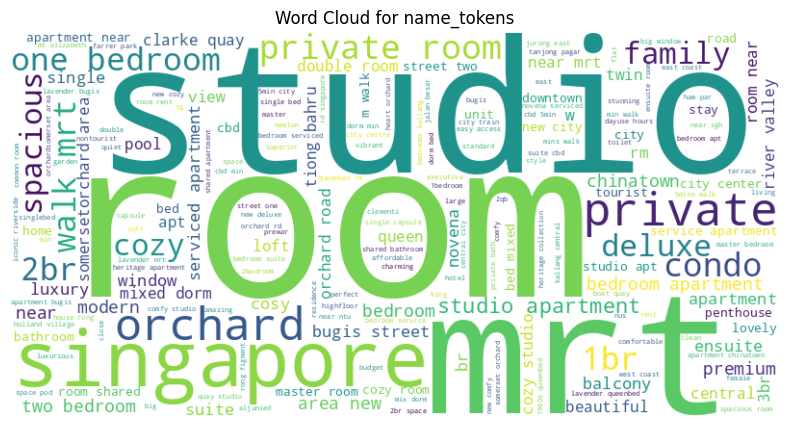

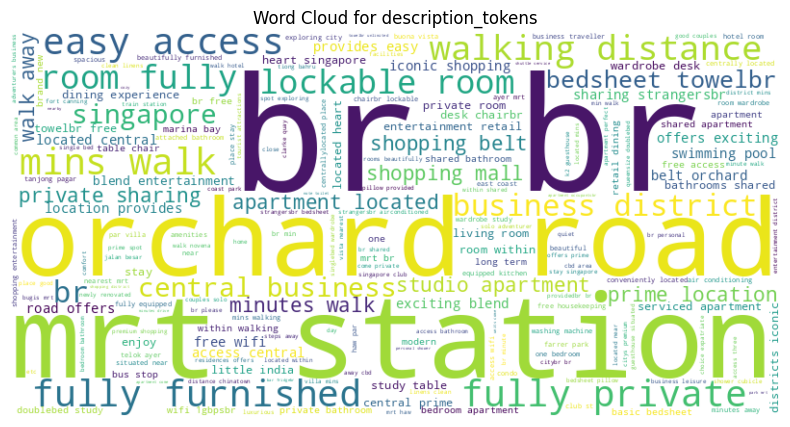

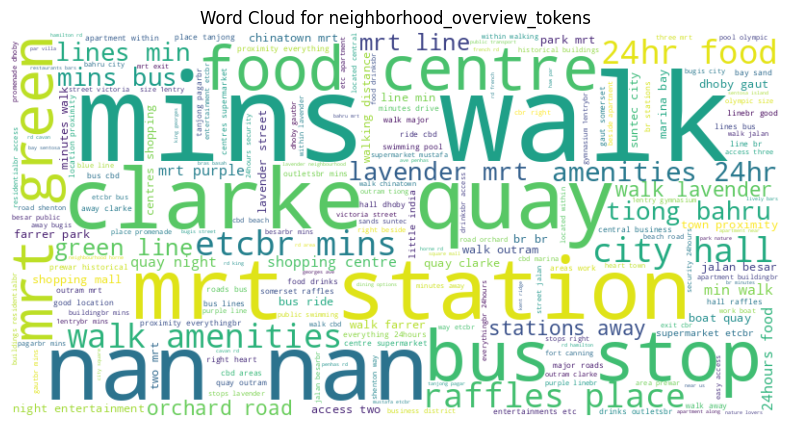

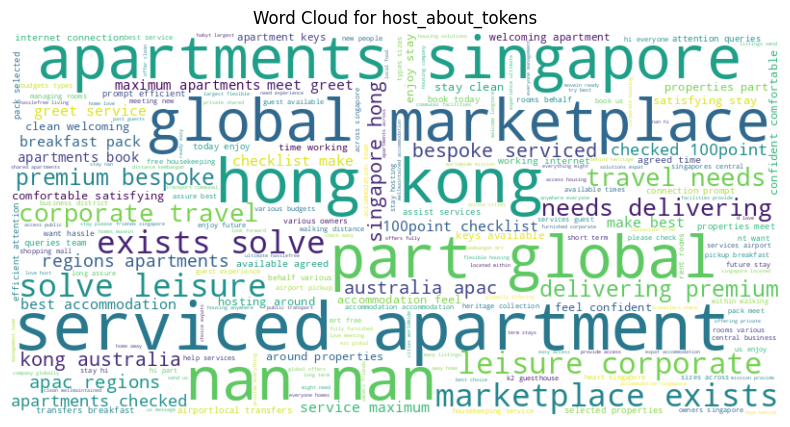

In [ ]:
# define columns to analyze
columns_to_analyze = ['name_tokens', 'description_tokens', 'neighborhood_overview_tokens', 'host_about_tokens']

# function to generate word cloud
def generate_wordcloud(column):
    all_tokens = [token for sublist in df_listings_tokens[column] for token in sublist]  # flatten list
    text = " ".join(all_tokens)  # convert list of words into a single string

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    # plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {column}")
    plt.show()

# generate word cloud for each column
for col in columns_to_analyze:
    generate_wordcloud(col)

## Review Word Cloud  
Reviews: 'host_about_tokens'.

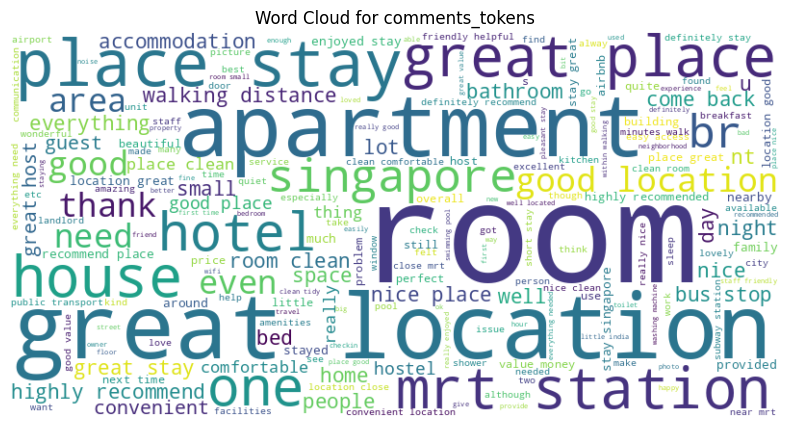

In [ ]:
# define columns to analyze
columns_to_analyze = ['comments_tokens']

# function to generate word cloud
def generate_wordcloud(column):
    all_tokens = [token for sublist in df_reviews_tokens[column] for token in sublist]  # flatten list
    text = " ".join(all_tokens)  # convert list of words into a single string

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    # plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {column}")
    plt.show()

# generate word cloud for each column
for col in columns_to_analyze:
    generate_wordcloud(col)

# TF-IDF and N-Gram Analysis

## TF-IDF and N-Gram for Listings

In [ ]:
def compute_tfidf_for_column(df, col):
    # Convert list of tokens to a single string (document) for each row.
    docs = df[col].apply(lambda tokens: " ".join(tokens))
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(docs)
    words = vectorizer.get_feature_names_out()
    # Sum up the TF-IDF scores of each word across all documents.
    scores = tfidf_matrix.sum(axis=0).A1
    return dict(zip(words, scores))

In [ ]:
def simple_weighted_ngrams(tokens, tfidf_dict, n=2):
    ngram_scores = {}
    for i in range(len(tokens) - n + 1):
        ngram = " ".join(tokens[i:i+n])
        weight = sum(tfidf_dict.get(token, 0) for token in tokens[i:i+n])
        ngram_scores[ngram] = weight
    return ngram_scores

In [ ]:
columns_to_analyze = ['name_tokens', 'description_tokens', 'neighborhood_overview_tokens', 'host_about_tokens']


Processing column: name_tokens


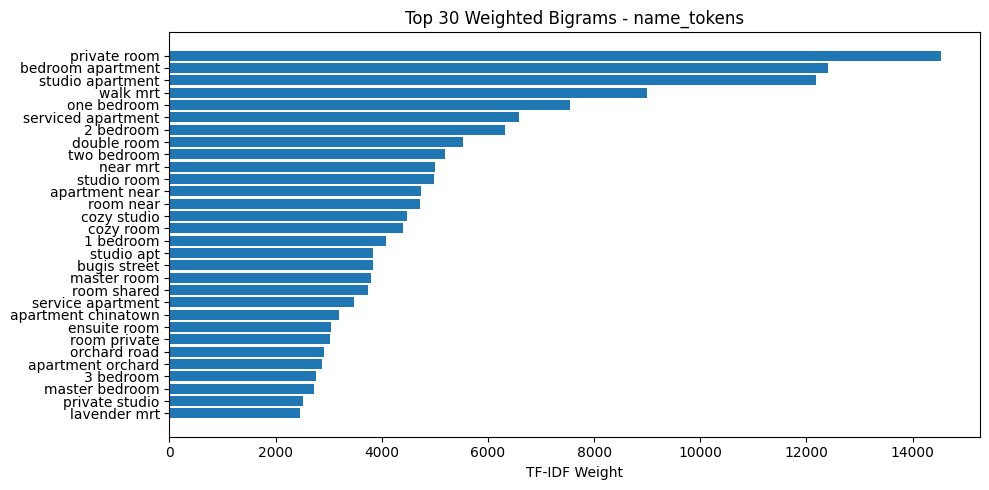


Processing column: description_tokens


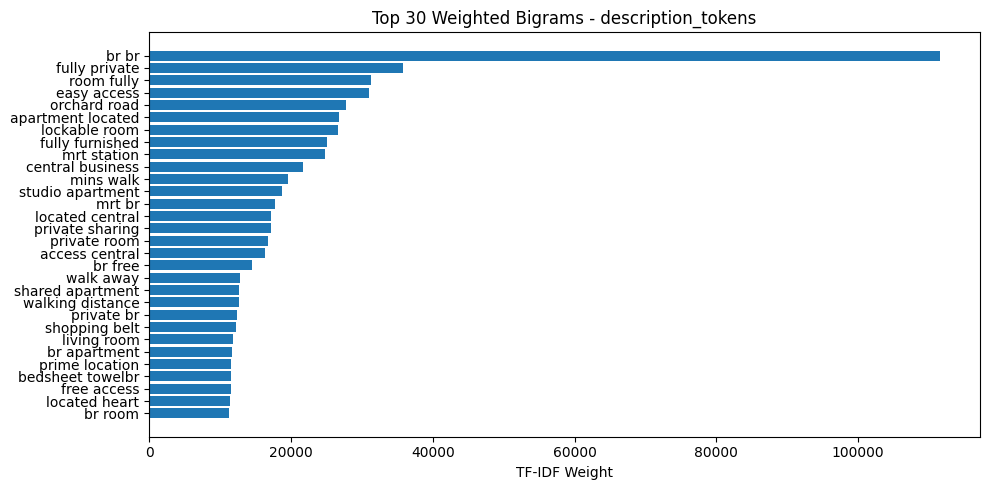


Processing column: neighborhood_overview_tokens


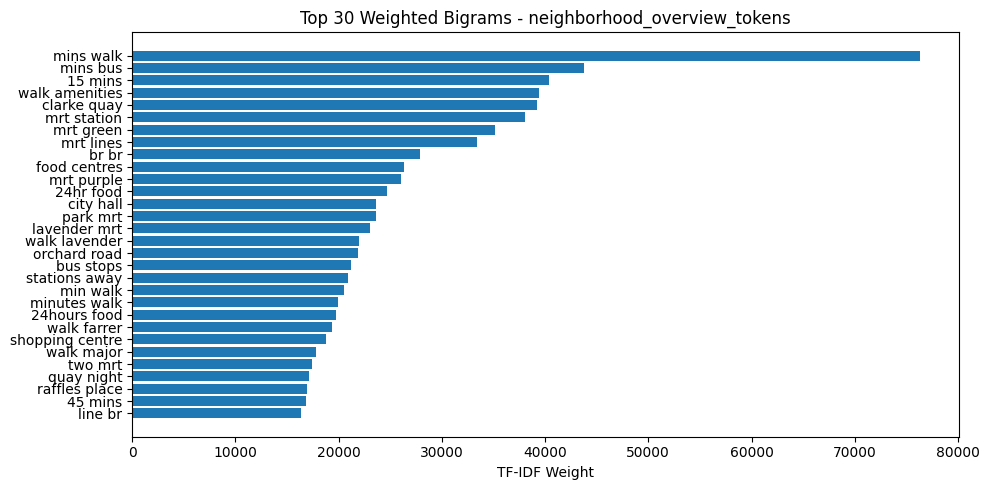


Processing column: host_about_tokens


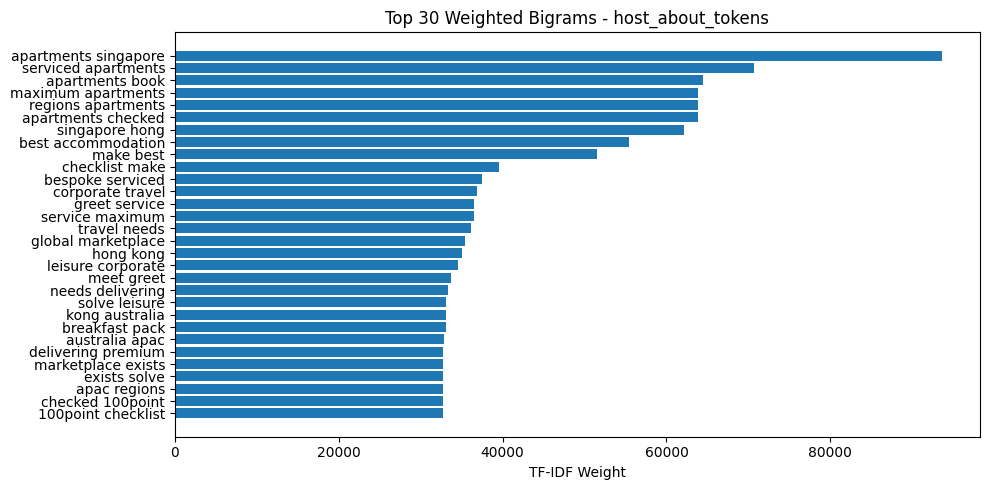

In [ ]:
# For Bi-Gram
for col in columns_to_analyze:
    print(f"\nProcessing column: {col}")

    # Step 1: Get TF-IDF scores
    tfidf_dict = compute_tfidf_for_column(df_listings_tokens, col)

    # Step 2: Collect n-grams across all rows
    total_ngram_scores = {}
    for tokens in df_listings_tokens[col]:
        if isinstance(tokens, list):
            ngrams_in_row = simple_weighted_ngrams(tokens, tfidf_dict, n=2)
            for ng, score in ngrams_in_row.items():
                total_ngram_scores[ng] = total_ngram_scores.get(ng, 0) + score

    # Step 3: Get top 30 bigrams
    top_ngrams = sorted(total_ngram_scores.items(), key=lambda x: x[1], reverse=True)[:30]
    labels, values = zip(*top_ngrams)

    # Step 4: Plot
    plt.figure(figsize=(10, 5))
    plt.barh(labels[::-1], values[::-1])  # reverse to show highest at top
    plt.title(f"Top 30 Weighted Bigrams - {col}")
    plt.xlabel("TF-IDF Weight")
    plt.tight_layout()
    plt.show()


Processing column (trigrams): name_tokens


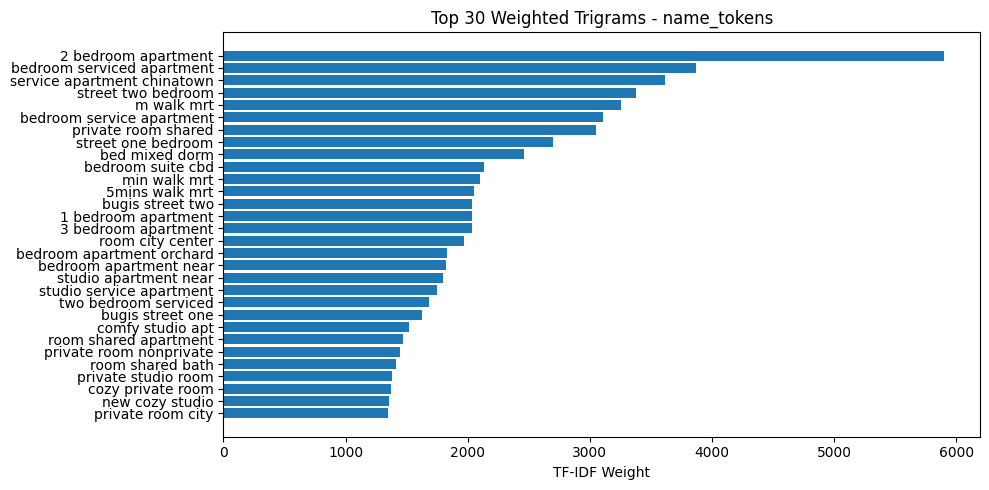


Processing column (trigrams): description_tokens


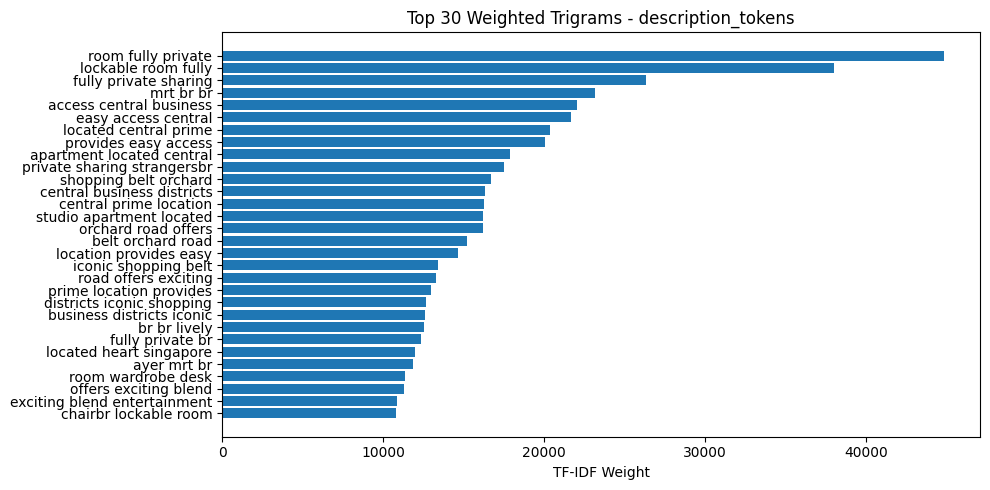


Processing column (trigrams): neighborhood_overview_tokens


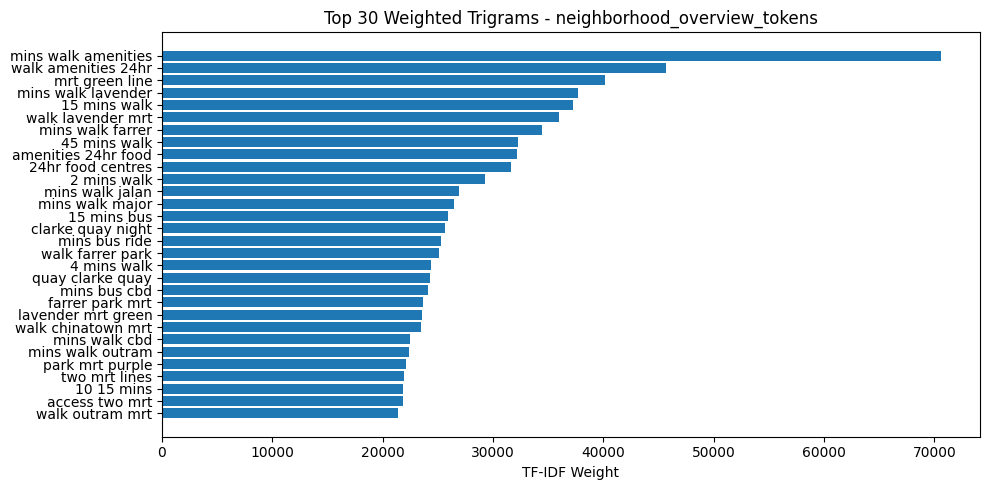


Processing column (trigrams): host_about_tokens


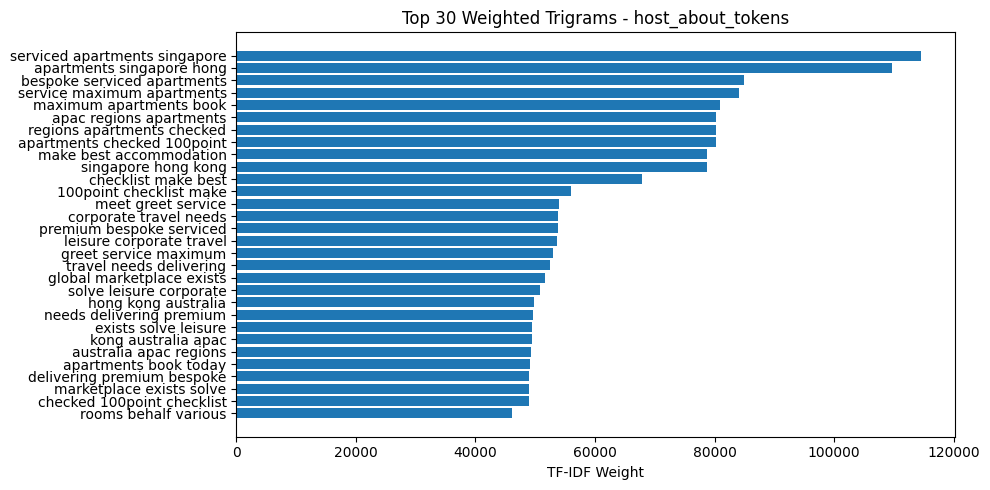

In [ ]:
# For Tri-Gram
for col in columns_to_analyze:
    print(f"\nProcessing column (trigrams): {col}")

    # Step 1: Get TF-IDF scores
    tfidf_dict = compute_tfidf_for_column(df_listings_tokens, col)

    # Step 2: Collect n-grams across all rows (n=3 for trigrams)
    total_ngram_scores = {}
    for tokens in df_listings_tokens[col]:
        if isinstance(tokens, list):
            ngrams_in_row = simple_weighted_ngrams(tokens, tfidf_dict, n=3)
            for ng, score in ngrams_in_row.items():
                total_ngram_scores[ng] = total_ngram_scores.get(ng, 0) + score

    # Step 3: Get top 30 trigrams
    top_ngrams = sorted(total_ngram_scores.items(), key=lambda x: x[1], reverse=True)[:30]
    labels, values = zip(*top_ngrams)

    # Step 4: Plot
    plt.figure(figsize=(10, 5))
    plt.barh(labels[::-1], values[::-1])  # reverse to show highest at top
    plt.title(f"Top 30 Weighted Trigrams - {col}")
    plt.xlabel("TF-IDF Weight")
    plt.tight_layout()
    plt.show()


Now, to do N-Gram analysis with segmenting High/Low rated listings.

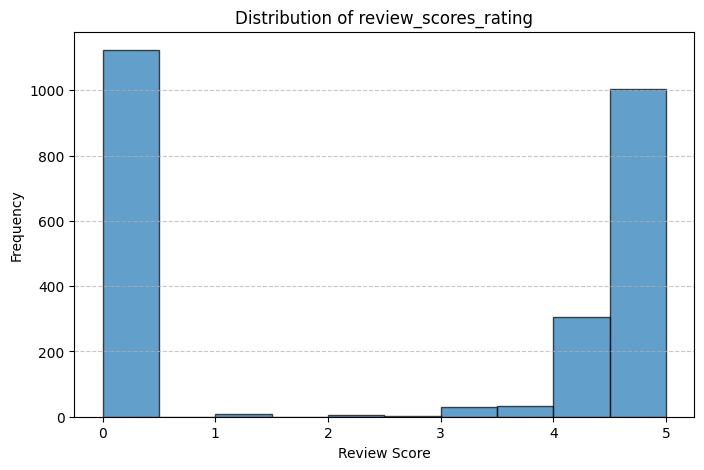

In [ ]:
# Define the review score columns
review_score_columns = ['review_scores_rating']

# Create separate histograms for each review score column
for column in review_score_columns:
    data = df_listings_tokens[column].dropna()

    # Define bins at every 0.1 interval between min and max values
    bins = np.arange(data.min(), data.max() + 0.1, 0.1)

    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(data, bins=bins, alpha=0.7, edgecolor="black")

    # Add value labels on top of each bar
    for count, patch in zip(counts, patches):
        plt.text(patch.get_x() + patch.get_width()/2, count + 1,  # +1 to raise the label above the bar
                 f'{int(count)}', ha='center', va='bottom', fontsize=9)

    plt.xlabel("Review Score")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {column}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(np.round(bins, 1), rotation=45)
    plt.tight_layout()
    plt.show()

According to: https://hospitable.com/airbnb-ratings/#:~:text=The%20Airbnb%20star%20rating%20scale,on%20what%20their%20listing%20promises.  
5-star means everything was as expected  
4-star means positive, but not enough, didnt meet guest expectation  
3-star or less, negative feedback  

I believe singstay should aim for at least a 4.8 star rating, hence we can segment the listings with ratings >= 4.8
 as high-rated and < 4.8 as low-rated.

In [ ]:
# Precompute TF-IDF weights
tfidf_word_weights = {
    col: compute_tfidf_for_column(df_listings_tokens, col)
    for col in columns_to_analyze
}

def get_top_ngrams_by_category(column, category, n=2, top_k=20):
    # Filter DataFrame based on 'review_scores_rating' instead of 'review_category'
    if category == 'High':
        filtered_df = df_listings_tokens[df_listings_tokens['review_scores_rating'] >= 4.8]
    else:  # Assuming category is 'Low'
        filtered_df = df_listings_tokens[df_listings_tokens['review_scores_rating'] < 4.8]

    tfidf_dict = tfidf_word_weights[column]

    ngram_scores = defaultdict(float)

    for tokens in filtered_df[column]:
        if isinstance(tokens, list) and len(tokens) >= n:
            for i in range(len(tokens) - n + 1):
                ngram = " ".join(tokens[i:i+n])
                weight = sum(tfidf_dict.get(token, 0) for token in tokens[i:i+n])
                ngram_scores[ngram] += weight

    return sorted(ngram_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

# Display side-by-side comparison tables
for col in columns_to_analyze:
    print(f"\n\n=== {col.upper()} ===")

    # Bigrams
    high_bigrams = get_top_ngrams_by_category(col, 'High', n=2)
    low_bigrams = get_top_ngrams_by_category(col, 'Low', n=2)

    bigrams_df = pd.DataFrame({
        'High-Rated Bigrams': [ng for ng, _ in high_bigrams],
        'Score (High)': [f"{score:.4f}" for _, score in high_bigrams],
        'Low-Rated Bigrams': [ng for ng, _ in low_bigrams],
        'Score (Low)': [f"{score:.4f}" for _, score in low_bigrams],
    })
    print("\nTop 20 Weighted Bigrams:")
    print(tabulate(bigrams_df, headers='keys', tablefmt='grid'))

    # Trigrams
    high_trigrams = get_top_ngrams_by_category(col, 'High', n=3)
    low_trigrams = get_top_ngrams_by_category(col, 'Low', n=3)

    trigrams_df = pd.DataFrame({
        'High-Rated Trigrams': [ng for ng, _ in high_trigrams],
        'Score (High)': [f"{score:.4f}" for _, score in high_trigrams],
        'Low-Rated Trigrams': [ng for ng, _ in low_trigrams],
        'Score (Low)': [f"{score:.4f}" for _, score in low_trigrams],
    })
    print("\nTop 20 Weighted Trigrams:")
    print(tabulate(trigrams_df, headers='keys', tablefmt='grid'))



=== NAME_TOKENS ===

Top 20 Weighted Bigrams:
+----+----------------------+----------------+---------------------+---------------+
|    | High-Rated Bigrams   |   Score (High) | Low-Rated Bigrams   |   Score (Low) |
+====+======================+================+=====================+===============+
|  0 | one bedroom          |       3057.5   | private room        |      12237    |
+----+----------------------+----------------+---------------------+---------------+
|  1 | walk mrt             |       2751.23  | bedroom apartment   |      10781    |
+----+----------------------+----------------+---------------------+---------------+
|  2 | serviced apartment   |       2661.03  | studio apartment    |       9581.63 |
+----+----------------------+----------------+---------------------+---------------+
|  3 | studio apartment     |       2595.03  | walk mrt            |       6252.8  |
+----+----------------------+----------------+---------------------+---------------+
|  4 | studio roo

## TF-IDF and N-Gram for Reviews

In [ ]:
def compute_tfidf_for_column_reviews(df, col):
    # Convert list of tokens to a single string per row
    docs = df[col].apply(lambda tokens: " ".join(tokens))
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(docs)
    words = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    return dict(zip(words, scores))

In [ ]:
def simple_weighted_ngrams(tokens, tfidf_dict, n=2):
    ngram_scores = {}
    for i in range(len(tokens) - n + 1):
        ngram = " ".join(tokens[i:i+n])
        weight = sum(tfidf_dict.get(token, 0) for token in tokens[i:i+n])
        ngram_scores[ngram] = weight
    return ngram_scores


In [ ]:
columns_to_analyze_reviews = ['comments_tokens']



Processing column (bigrams): comments_tokens


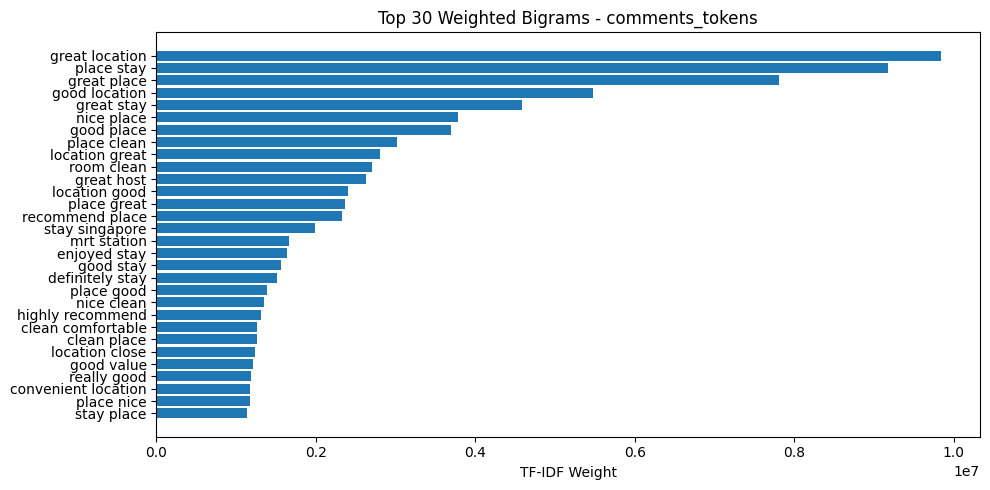

In [ ]:
import matplotlib.pyplot as plt

for col in columns_to_analyze_reviews:
    print(f"\nProcessing column (bigrams): {col}")

    # Step 1: Compute TF-IDF
    tfidf_dict = compute_tfidf_for_column_reviews(df_reviews_tokens, col)

    # Step 2: Aggregate bigram scores
    total_ngram_scores = {}
    for tokens in df_reviews_tokens[col]:
        if isinstance(tokens, list):
            ngrams_in_row = simple_weighted_ngrams(tokens, tfidf_dict, n=2)
            for ng, score in ngrams_in_row.items():
                total_ngram_scores[ng] = total_ngram_scores.get(ng, 0) + score

    # Step 3: Get top 30 bigrams
    top_ngrams = sorted(total_ngram_scores.items(), key=lambda x: x[1], reverse=True)[:30]
    labels, values = zip(*top_ngrams)

    # Step 4: Plot
    plt.figure(figsize=(10, 5))
    plt.barh(labels[::-1], values[::-1])
    plt.title(f"Top 30 Weighted Bigrams - {col}")
    plt.xlabel("TF-IDF Weight")
    plt.tight_layout()
    plt.show()



Processing column (trigrams): comments_tokens


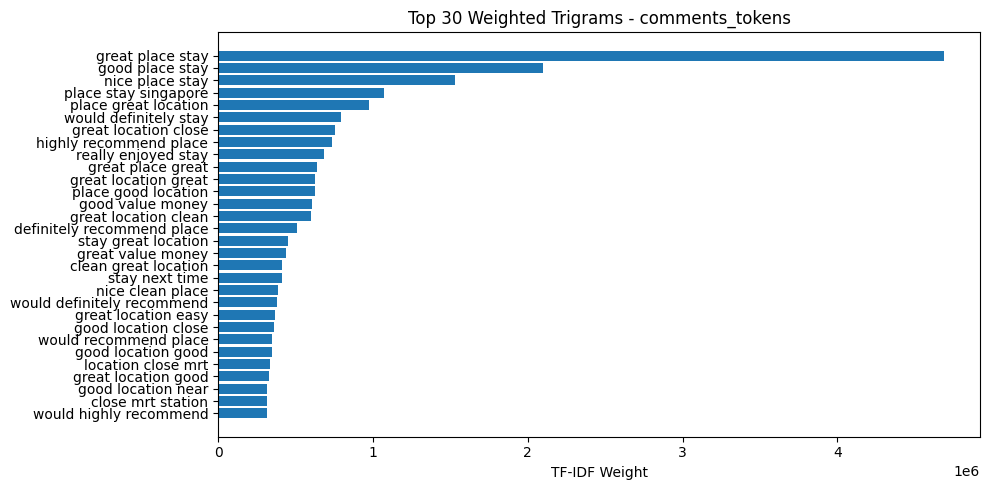

In [ ]:
for col in columns_to_analyze_reviews:
    print(f"\nProcessing column (trigrams): {col}")

    # Step 1: Compute TF-IDF
    tfidf_dict = compute_tfidf_for_column_reviews(df_reviews_tokens, col)

    # Step 2: Aggregate trigram scores
    total_ngram_scores = {}
    for tokens in df_reviews_tokens[col]:
        if isinstance(tokens, list):
            ngrams_in_row = simple_weighted_ngrams(tokens, tfidf_dict, n=3)
            for ng, score in ngrams_in_row.items():
                total_ngram_scores[ng] = total_ngram_scores.get(ng, 0) + score

    # Step 3: Get top 30 trigrams
    top_ngrams = sorted(total_ngram_scores.items(), key=lambda x: x[1], reverse=True)[:30]
    labels, values = zip(*top_ngrams)

    # Step 4: Plot
    plt.figure(figsize=(10, 5))
    plt.barh(labels[::-1], values[::-1])
    plt.title(f"Top 30 Weighted Trigrams - {col}")
    plt.xlabel("TF-IDF Weight")
    plt.tight_layout()
    plt.show()


# LDA Topic Modelling

In [ ]:
# Read a new df_listing_topicmodelling directly from the excel file
df_listings_topicmodelling = pd.read_excel('df_listings_tokens.xlsx')
df_reviews_topicmodelling = pd.read_excel('df_reviews_tokens.xlsx')

def fix_list_strings(cell):
    if isinstance(cell, str):
        try:
            return ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            return []
    return cell

#Apply to df_listings_topicmodelling['name_tokens', 'description_tokens', 'neighborhood_overview_tokens','host_about_tokens']
for col in ['name_tokens', 'description_tokens', 'neighborhood_overview_tokens','host_about_tokens']:
    df_listings_topicmodelling[col] = df_listings_topicmodelling[col].apply(fix_list_strings)

# Apply to the column
df_reviews_topicmodelling['comments_tokens'] = df_reviews_topicmodelling['comments_tokens'].apply(fix_list_strings)

## Listings Topic Modelling

In [ ]:
threshold_score = 4.8
df_listings_topicmodelling['listing rating category'] = np.where(df_listings_topicmodelling['review_scores_rating'] >= threshold_score,'high', 'low')

In [ ]:
def combine_tokens(row):
    def tokenize_if_needed(doc):
        if isinstance(doc, list):
            return doc
        elif isinstance(doc, str):
            return doc.split()
        else:
            return []

    token_fields = ['name_tokens', 'description_tokens', 'neighborhood_overview_tokens', 'host_about_tokens']
    combined = []
    for field in token_fields:
        combined += tokenize_if_needed(row[field])
    return combined

df_listings_topicmodelling['combined_tokens'] = df_listings_topicmodelling.apply(combine_tokens, axis=1)
print(df_listings_topicmodelling[['id', 'combined_tokens']].head())

       id                                    combined_tokens
0  275343  in, walk, mrt, cozy, room, window, 1, impo...
1  275343  in, walk, mrt, cozy, room, window, 1, impo...
2  275344  [15, mins, outram, mrt, single, room, 2, lovel...
3  294281  [5, mins, walk, newton, subway, 3, bedrooms, c...
4  324945  [comfortable, room, wstudy, area, redhill, mrt...


In [ ]:
texts = df_listings_topicmodelling['combined_tokens'].tolist()
texts = [text for text in texts if text]

# Create dictionary
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=2, no_above=0.95)

corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
lda_model = models.LdaModel(
    corpus,
    num_topics=10,
    id2word=dictionary,
    passes=10,
    random_state=42
)


Topic Modelling Results

In [ ]:
lda_model.save('lda_listing_model.model')

In [ ]:
for topic_id, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {topic_id}: {topic}")

Topic 0: 0.029*"br" + 0.028*"walk" + 0.023*"mins" + 0.023*"mrt" + 0.015*"room" + 0.013*"bus" + 0.011*"apartment" + 0.010*"outram" + 0.010*"food" + 0.010*"etcbr"
Topic 1: 0.016*"singapore" + 0.011*"heritage" + 0.011*"’" + 0.011*"business" + 0.011*"village" + 0.011*"holland" + 0.010*"experience" + 0.010*"one" + 0.009*"sentosa" + 0.009*"br"
Topic 2: 0.018*"br" + 0.017*"experience" + 0.017*"us" + 0.015*"local" + 0.012*"home" + 0.012*"k2" + 0.012*"guesthouse" + 0.012*"food" + 0.010*"love" + 0.010*"vista"
Topic 3: 0.032*"br" + 0.018*"singapore" + 0.016*"mrt" + 0.013*"apartment" + 0.011*"walk" + 0.010*"bahru" + 0.010*"novena" + 0.010*"within" + 0.009*"bugis" + 0.009*"tiong"
Topic 4: 0.036*"br" + 0.023*"singapore" + 0.013*"located" + 0.012*"mrt" + 0.011*"street" + 0.011*"chinatown" + 0.011*"walk" + 0.008*"away" + 0.008*"temple" + 0.007*"city"
Topic 5: 0.029*"br" + 0.027*"nan" + 0.011*"room" + 0.009*"singapore" + 0.008*"mrt" + 0.008*"park" + 0.008*"new" + 0.007*"shopping" + 0.007*"stay" + 0.007

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis
#please run this cell to ensure the visualisation is dynamic when sliding lamda value

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.124288  0.096836       1        1  23.113097
5      0.043101  0.021294       2        1  16.521942
4      0.021741  0.057314       3        1  11.229665
9     -0.288898 -0.021900       4        1  10.971183
0     -0.244474 -0.030190       5        1   9.944921
3     -0.004448  0.091324       6        1   8.455131
1      0.187221 -0.009356       7        1   5.725511
2      0.093253 -0.296567       8        1   5.452576
7      0.039564 -0.064860       9        1   5.292555
8      0.028651  0.156105      10        1   3.293419, topic_info=               Term         Freq        Total Category  logprob  loglift
129            mins  2096.000000  2096.000000  Default  30.0000  30.0000
116            walk  2847.000000  2847.000000  Default  29.0000  29.0000
311           bugis   799.000000   799.000000  Default  28.0000  28.0000
20               br  5112.000000  5112.000000  Default  27.0000  27.0000
73              nan  2609.000000  2609.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
629         walking    76.122554   575.071970  Topic10  -4.7523   1.3911
70              min    71.583898   385.170646  Topic10  -4.8138   1.7304
96        singapore    81.708790  3191.378819  Topic10  -4.6815  -0.2518
231   accommodation    73.180554   690.248624  Topic10  -4.7917   1.1691
2411       provides    70.892454   487.135779  Topic10  -4.8235   1.4859

[746 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
0         1  0.077017                       1
0         2  0.394712                       1
0         3  0.128362                       1
0         5  0.304859                       1
0         6  0.046531                       1
...     ...       ...                     ...
1013     10  0.176532                       ’
1909      6  0.995301                       •
5633      4  0.966090                       ⭐
2680      6  0.944503       居住生活新方式，生活其实可以更简单
2681      6  0.944504  新加坡唯一专业致力于高端别墅的酒店式服务公寓

[1861 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 5, 10, 1, 4, 2, 3, 8, 9])

In [ ]:
print(df_listings_topicmodelling['combined_tokens'].iloc[0])
print(type(df_listings_topicmodelling['combined_tokens'].iloc[0]))

['10min', 'walk', 'mrt', 'cozy', 'room', 'window', '1', 'important', 'notes', 'read', 'book', 'br', 'since', 'hdb', 'flat', 'tourists', 'allowed', 'unless', 'valid', 'pass', 'like', 'ipa', 'letter', 'tepbr', 'br', 'cozy', 'comfortable', 'wellrenovated', 'fitted', 'great', 'guests', 'great', 'environmentbr', 'br', 'shared', 'apartment', 'several', 'flatmatesbr', '2', 'common', 'bathrooms', '2', 'toilets', 'separate', 'br', '10', 'min', 'walk', 'redhill', 'mrt', 'take', 'bus', 'direct', 'bus', 'terminal', 'downstairs', 'direct', 'tiong', 'bahru', 'mrtbr', 'near', 'queensway', 'alexandra', 'nus', 'nuh', 'nan', 'k2', 'guesthouse', 'designed', 'guests', 'want', 'truly', 'local', 'experience', 'local', 'people', 'experience', 'eating', 'local', 'food', 'local', 'home', 'away', 'home', 'love', 'meeting', 'new', 'people', 'exchanging', 'cultures', 'food', 'language', 'spending', 'time', 'evening', 'work', 'relax', 'glass', 'wine', 'beer', 'weather', 'becomes', 'unbearable', 'read', 'reviews', 

In [ ]:
# Topic distribution
def get_topic_distribution(tokens):
    bow = dictionary.doc2bow(tokens)
    return lda_model.get_document_topics(bow)

df_listings_topicmodelling['topic_distribution'] = df_listings_topicmodelling['combined_tokens'].apply(get_topic_distribution)

# Dominant topic
def extract_dominant_topic(topic_dist):
    if topic_dist:
        return max(topic_dist, key=lambda x: x[1])[0]
    return None

df_listings_topicmodelling['dominant_topic'] = df_listings_topicmodelling['topic_distribution'].apply(extract_dominant_topic)


Topic Distribution by Listing Rating Category:
   listing rating category  dominant_topic  counts
0                     high               0      66
1                     high               1      34
2                     high               2      15
3                     high               3      70
4                     high               4      32
5                     high               5     187
6                     high               6     123
7                     high               7      10
8                     high               8      27
9                     high               9      96
10                     low               0     114
11                     low               1      65
12                     low               2      75
13                     low               3      80
14                     low               4     164
15                     low               5     522
16                     low               6     503
17                     low        

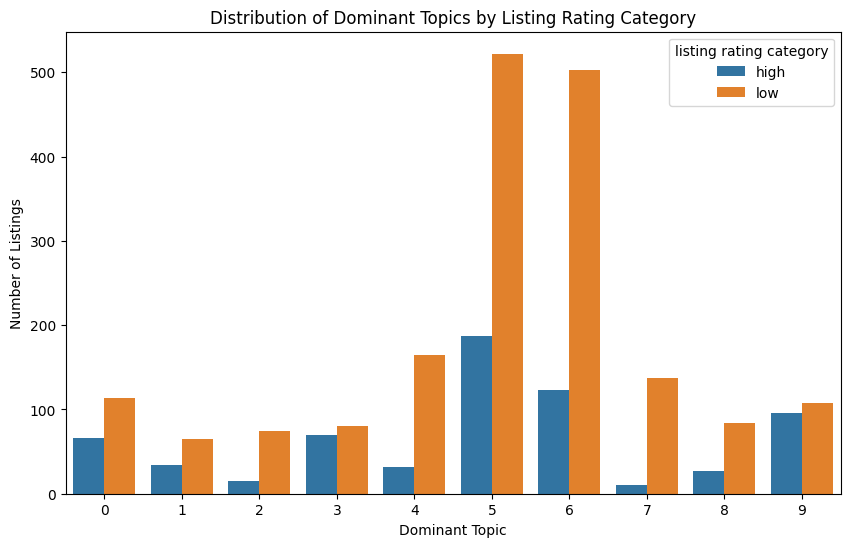

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

topic_counts = df_listings_topicmodelling.groupby(
    ['listing rating category', 'dominant_topic']
).size().reset_index(name='counts')

print("\nTopic Distribution by Listing Rating Category:")
print(topic_counts)

plt.figure(figsize=(10,6))
sns.barplot(data=topic_counts, x='dominant_topic', y='counts', hue='listing rating category')
plt.title('Distribution of Dominant Topics by Listing Rating Category')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Listings')
plt.show()

In [ ]:
#export df_listings_topicmodelling as excel file
df_listings_topicmodelling.to_excel('df_listings_topicmodelling_results.xlsx', index=False)

## Reviews Topic Modelling

In [ ]:
def fix_list_strings(cell):
    if isinstance(cell, str):
        try:
            return ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            return []
    return cell

# Apply to the column
df_reviews_topicmodelling['comments_tokens'] = df_reviews_topicmodelling['comments_tokens'].apply(fix_list_strings)


In [ ]:
texts_reviews = df_reviews_topicmodelling['comments_tokens'].tolist()
texts_reviews = [text for text in texts_reviews if isinstance(text, list) and text]

print(f"Number of valid reviews: {len(texts_reviews)}")


Number of valid reviews: 39141


In [ ]:
dictionary_reviews = corpora.Dictionary(texts_reviews)
dictionary_reviews.filter_extremes(no_below=1, no_above=1.0)
corpus_reviews = [dictionary_reviews.doc2bow(text) for text in texts_reviews]

In [ ]:
num_topics_reviews = 10

lda_model_reviews = models.LdaModel(
    corpus_reviews,
    num_topics=num_topics_reviews,
    id2word=dictionary_reviews,
    passes=10,
    random_state=42
)


In [ ]:
lda_model_reviews.save('lda_reviews_model.model')

In [ ]:
for topic_id, topic in lda_model_reviews.print_topics(num_words=10):
    print(f"Topic {topic_id}: {topic}")

Topic 0: 0.034*"apartment" + 0.027*"br" + 0.019*"pool" + 0.017*"kitchen" + 0.015*"well" + 0.014*"washing" + 0.012*"machine" + 0.010*"also" + 0.009*"swimming" + 0.007*"two"
Topic 1: 0.035*"room" + 0.021*"nt" + 0.016*"br" + 0.015*"night" + 0.011*"small" + 0.009*"one" + 0.008*"could" + 0.008*"bed" + 0.008*"little" + 0.008*"sleep"
Topic 2: 0.023*"us" + 0.023*"time" + 0.020*"singapore" + 0.018*"stay" + 0.014*"house" + 0.012*"also" + 0.011*"next" + 0.011*"come" + 0.010*"place" + 0.010*"thank"
Topic 3: 0.075*"👍" + 0.066*"enthusiastic" + 0.028*"🏻" + 0.021*"villa" + 0.020*"attention" + 0.016*"…" + 0.015*"landlords" + 0.013*"goodthe" + 0.011*"lorraine" + 0.010*"container"
Topic 4: 0.119*"landlord" + 0.094*"check" + 0.069*"easy" + 0.048*"checkin" + 0.020*"clear" + 0.019*"smooth" + 0.015*"process" + 0.014*"communication" + 0.012*"instructions" + 0.012*"owner"
Topic 5: 0.032*"’" + 0.018*"room" + 0.012*"hotel" + 0.010*"would" + 0.008*"stay" + 0.008*"like" + 0.008*"check" + 0.007*"staff" + 0.007*"sma

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis_reviews = gensimvis.prepare(lda_model_reviews, corpus_reviews, dictionary_reviews)
vis_reviews

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.179896  0.023238       1        1  19.256762
6     -0.097658 -0.168280       2        1  16.487728
9     -0.117079 -0.226081       3        1  16.068867
1     -0.158895  0.187058       4        1  14.118162
5     -0.118654  0.099574       5        1  11.607191
7     -0.107870 -0.026621       6        1   8.711925
0     -0.020761  0.194581       7        1   7.364210
8      0.172901 -0.211850       8        1   3.071946
4      0.293664  0.056665       9        1   2.095615
3      0.334247  0.071717      10        1   1.217596, topic_info=           Term          Freq         Total Category  logprob  loglift
126        good  12511.000000  12511.000000  Default  30.0000  30.0000
121    location  12391.000000  12391.000000  Default  29.0000  29.0000
53        great  13675.000000  13675.000000  Default  28.0000  28.0000
88         stay  14637.000000  14637.000000  Default  27.0000  27.0000
26        place  13836.000000  13836.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
6012      units     42.682629     43.748583  Topic10  -5.4826   4.3836
4179     hidden     42.682657     43.748623  Topic10  -5.4826   4.3836
8305         de     41.299706     42.365574  Topic10  -5.5155   4.3828
20200  lorraine    112.106002    148.882746  Topic10  -4.5169   4.1246
3111        man     48.174088     92.199185  Topic10  -5.3615   3.7592

[623 rows x 6 columns], token_table=       Topic      Freq Term
term                       
684        1  0.071315    2
684        2  0.230246    2
684        4  0.457776    2
684        6  0.012225    2
684        7  0.228209    2
...      ...       ...  ...
5346       6  0.990498    👌
2315      10  0.999109    👍
7524       3  0.967242    😀
13256      3  0.983571    😃
6681       9  0.994326    🙏

[1147 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 10, 2, 6, 8, 1, 9, 5, 4])

In [ ]:
def get_topic_distribution(tokens):
    bow = dictionary_reviews.doc2bow(tokens)
    return lda_model_reviews.get_document_topics(bow)

df_reviews_topicmodelling['topic_distribution'] = df_reviews_topicmodelling['comments_tokens'].apply(get_topic_distribution)

def extract_dominant_topic(topic_dist):
    if topic_dist:
        return max(topic_dist, key=lambda x: x[1])[0]
    return None

df_reviews_topicmodelling['dominant_topic'] = df_reviews_topicmodelling['topic_distribution'].apply(extract_dominant_topic)

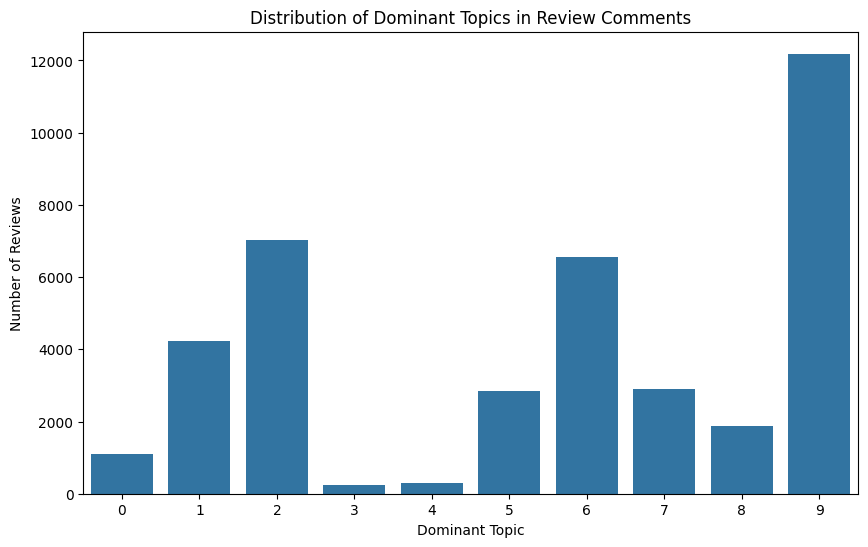

In [ ]:
topic_counts_reviews = df_reviews_topicmodelling['dominant_topic'].value_counts().reset_index()
topic_counts_reviews.columns = ['Topic', 'Number of Reviews']

plt.figure(figsize=(10,6))
sns.barplot(data=topic_counts_reviews, x='Topic', y='Number of Reviews')
plt.title('Distribution of Dominant Topics in Review Comments')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
# export df_reviews_topicmodelling as excel
df_reviews_topicmodelling.to_excel('df_reviews_topicmodelling_results.xlsx', index=False)